# RL Controller Training and Testing
This notebook demonstrates the training and evaluation of an RL agent for microgrid control.

## Importing Libraries and Setup

In [1]:
import sys, os
import pandas as pd

from stable_baselines3.common.monitor import Monitor

# Path setup
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)

# Import simulation components
from microgrid_sim.core.gym_wrapper import MicrogridGymEnv
from microgrid_sim.control.rl_controller import RLController
from microgrid_sim.data import SyntheticDataBuilder
from microgrid_sim.utils import plot_simulation, plot_reward_progress
from microgrid_sim.components.generators import PVGenerator, WindTurbine, FossilGenerator, GridIntertie, ReliabilityParams
from microgrid_sim.components.storage import BatteryStorage
from microgrid_sim.components.loads import ResidentialLoad, FactoryLoad
from microgrid_sim.core.environment import MicrogridEnv
from microgrid_sim.control import RuleBasedEMS
from microgrid_sim.control.rules import BatteryRule, DieselRule, GridRule, TimeSchedule, RenewableDisconnectRule

print("Imports OK")

Imports OK


## Configuration

In [ ]:
# --- Global Constants ---
NO_OF_EPISODES = 500
TOTAL_HOURS = 24 * 7  # Total data available
CONTROL_DT = 60  # Control interval in minutes
SIM_DT = 60  # Simulation timestep in minutes
SEED = 100

# --- Training Parameters (Light training for quick testing) ---
CONTROL_STEPS_PER_EP = (TOTAL_HOURS * 60) // CONTROL_DT  # 24 steps per episode
TRAINING_TIMESTEPS = CONTROL_STEPS_PER_EP * NO_OF_EPISODES
EVAL_FREQ = CONTROL_STEPS_PER_EP * 20 # Evaluate after every 20 episodes during training
N_EVAL_EPISODES = 5

# Reward Function Weights
UNUSED_POWER_COST = 3.5
WASTED_POWER_COST = 1.5
reward_weights={
    "cost": 5.0,
    "unmet": 10.0 * UNUSED_POWER_COST,
    "curtailment": 0.1 * WASTED_POWER_COST,
    "soc_deviation": 0.0,
}

# Paths
MODEL_DIR = "./models"
LOG_DIR = "./logs/ppo_training"
RESULTS_DIR = "./plots/05_rl_testing"

os.makedirs(MODEL_DIR, exist_ok=True)
os.makedirs(LOG_DIR, exist_ok=True)
os.makedirs(RESULTS_DIR, exist_ok=True)

print("Configuration complete.")
print(f"Control steps per episode: {CONTROL_STEPS_PER_EP}")
print(f"Total training timesteps: {TRAINING_TIMESTEPS}")


Configuration complete.
Control steps per episode: 168
Total training timesteps: 84000


## Data Generation Helpers

In [3]:
def setup_data_builder(seed: int) -> SyntheticDataBuilder:
    """Creates a configured data builder."""
    builder = SyntheticDataBuilder(
        total_hours=TOTAL_HOURS,
        sim_dt_minutes=SIM_DT,
        seed=seed
    )

    # Add components - MUST match MicrogridEnv component names
    builder.add_pv("pv", peak_irr=900)
    builder.add_wind("wind", mean_speed=6.0)
    builder.add_grid_prices("grid")

    return builder


def setup_microgrid_env(seed: int | None = None) -> MicrogridEnv:
    """Creates a configured MicrogridEnv with all components."""
    env = MicrogridEnv(
        simulation_hours=TOTAL_HOURS,
        control_interval_minutes=CONTROL_DT,
        sim_dt_minutes=SIM_DT
    )

    # --- Add Components (names must match data builder) ---

    pv_rel = ReliabilityParams(
        base_fail_rate_per_hour=0.05,
        minor_prob_fraction=0.6,
        minor_derate=0.5,
        mttr_minor_hours=2,
        mttr_major_hours=8,
        maint_cost_per_hour=5.0,
        exo_keys=("irradiance_Wm2",),  # hazard rises with irradiance above shift
        exo_weight=0.002,
        exo_shift=800.0,
    )

    pv = PVGenerator(
        "pv",
        capacity_kw=350.0,
        time_step_minutes=SIM_DT,
        operational_cost_per_kwh=0.02,
        reliability=pv_rel,
        )

    wind_rel = ReliabilityParams(
        base_fail_rate_per_hour=0.08,
        minor_prob_fraction=0.7,
        minor_derate=0.6,
        mttr_minor_hours=6,
        mttr_major_hours=16,
        maint_cost_per_hour=7.0,
        exo_keys=("wind_speed_ms",),  # hazard rises with wind speed above shift
        exo_weight=0.01,
        exo_shift=8.0,
    )

    wind = WindTurbine(
        "wind", rated_kw=200.0,
        time_step_minutes=SIM_DT,
        operational_cost_per_kwh=0.027,
        reliability=wind_rel,
        )

    diesel_rel = ReliabilityParams(
        base_fail_rate_per_hour=0.05,
        minor_prob_fraction=0.5,
        minor_derate=0.7,
        mttr_minor_hours=4,
        mttr_major_hours=12,
        maint_cost_per_hour=10.0,
        exo_keys=(),
        exo_weight=0.0,
        exo_shift=0.0,
    )

    diesel = FossilGenerator(
        "diesel", p_min_kw=0.0, p_max_kw=200.0,
        time_step_minutes=SIM_DT,
        fuel_cost_per_kwh=0.45, # ~1.66 SAR/L × 0.27 L/kWh
        operational_cost_per_hour=1.0,
        reliability=diesel_rel,
        )

    house = ResidentialLoad("house", base_kw=200.0, noise_std=0.15, seed=seed)

    factory = FactoryLoad("factory", base_kw=450.0, noise_std=0.5, seed=seed)

    bat_rel = ReliabilityParams(
        base_fail_rate_per_hour=0.01,
        minor_prob_fraction=0.9,
        minor_derate=0.95,
        mttr_minor_hours=1,
        mttr_major_hours=4,
        maint_cost_per_hour=2.0,
        exo_keys=(),
        exo_weight=0.0,
        exo_shift=0.0,
    )

    BAT_CAPACITY_KW = 411.0
    bat = BatteryStorage(
        "bat",
        capacity_kwh=BAT_CAPACITY_KW * 4,
        time_step_minutes=SIM_DT,
        max_charge_kw=BAT_CAPACITY_KW/4,
        max_discharge_kw=BAT_CAPACITY_KW/4,
        degradation_cost_per_kwh=0.086,
        reliability=bat_rel,
    )

    grid_rel = ReliabilityParams(
        base_fail_rate_per_hour=0.01,
        minor_prob_fraction=0.8,
        minor_derate=0.9,
        mttr_minor_hours=2,
        mttr_major_hours=8,
        maint_cost_per_hour=0.0,
        exo_keys=(),
        exo_weight=0.0,
        exo_shift=0.0,
    )

    grid = GridIntertie(
        "grid", time_step_minutes=SIM_DT,
        import_limit_kw=1000.0,
        export_limit_kw=1000.0,
        price_export_per_kwh=0.20,
        price_import_per_kwh=0.20,
        reliability=grid_rel,
    )

    # Add all components
    for c in [pv, wind, diesel, house, factory, bat]:
        env.add_component(c)

    env.add_component(grid, is_grid=True)

    return env


def setup_ems_controller() -> RuleBasedEMS:
    """Sets up a simple, heuristic EMS for baseline comparison."""
    rules = [
        BatteryRule(
            name="bat",
            charge_schedule=TimeSchedule(11, 15),
            discharge_schedule=TimeSchedule(18, 22),
            charge_kw=-100.0,
            discharge_kw=100.0
        ),
        DieselRule(
            name="diesel",
            run_schedule=TimeSchedule(22, 6),
            setpoint_kw=150.0
        ),
        GridRule(name="grid"),
        RenewableDisconnectRule(name="pv"),
        RenewableDisconnectRule(name="wind"),
    ]

    return RuleBasedEMS(rules=rules)

print("Helper functions defined.")

Helper functions defined.


## Data and Environment Setup

In [4]:
print("\n=== Setting up environments ===")

# 1. Create MicrogridEnv instances (separate for train/eval)
base_env_train = setup_microgrid_env()
base_env_eval = setup_microgrid_env()
base_env_test = setup_microgrid_env()

# 2. Create Data Builders (different seeds for train/eval)
data_builder_train = setup_data_builder(SEED)
data_builder_eval = setup_data_builder(SEED + 100)
data_builder_test = setup_data_builder(SEED + 200)

# 3. Create Gym Environments (Dict Action Space)
train_env_dict = MicrogridGymEnv(
    microgrid_env=base_env_train,
    data_builder=data_builder_train,
    reward_weights=reward_weights,
)

eval_env_dict = MicrogridGymEnv(
    microgrid_env=base_env_eval,
    data_builder=data_builder_eval,
    reward_weights=reward_weights,
)

test_env_dict = MicrogridGymEnv(
    microgrid_env=base_env_test,
    data_builder=data_builder_test,
    reward_weights=reward_weights,
)

# 4. Apply Flattener Wrapper for SB3 compatibility
train_env = train_env_dict.create_flattened_env()
eval_env = eval_env_dict.create_flattened_env()
test_env = test_env_dict.create_flattened_env()

train_monitor_path = os.path.join(LOG_DIR, "monitor_train")
eval_monitor_path  = os.path.join(LOG_DIR, "monitor_eval")

train_env = Monitor(train_env, filename=train_monitor_path)
eval_env  = Monitor(eval_env,  filename=eval_monitor_path)

print(f"\nOriginal Dict Action Space Keys: {list(train_env_dict.action_space.keys())}")
print(f"Flattened Box Action Space: {train_env.action_space}")
print(f"Observation Space Keys: {list(train_env_dict.observation_space.keys())}")
print("\nEnvironments created successfully.")


=== Setting up environments ===

Original Dict Action Space Keys: ['bat_mag', 'bat_mode', 'diesel_on', 'diesel_sp', 'grid_mode', 'grid_trade', 'pv_con', 'wind_con']
Flattened Box Action Space: Box(-1.0, 1.0, (15,), float32)
Observation Space Keys: ['bat_soc', 'diesel_p', 'factory_l', 'grid_p_exp', 'grid_p_imp', 'house_l', 'pv_p', 'wind_p']

Environments created successfully.


## Using Rule-Based EMS


=== Evaluating Rule-Based EMS ===
Rule-Based EMS - Total Reward: -40429.09
Rule-Based EMS - Total Cost: $-8085.82
Rule-Based EMS - Average Cost per Timestep: $-48.13
Rule-based EMS evaluation complete.



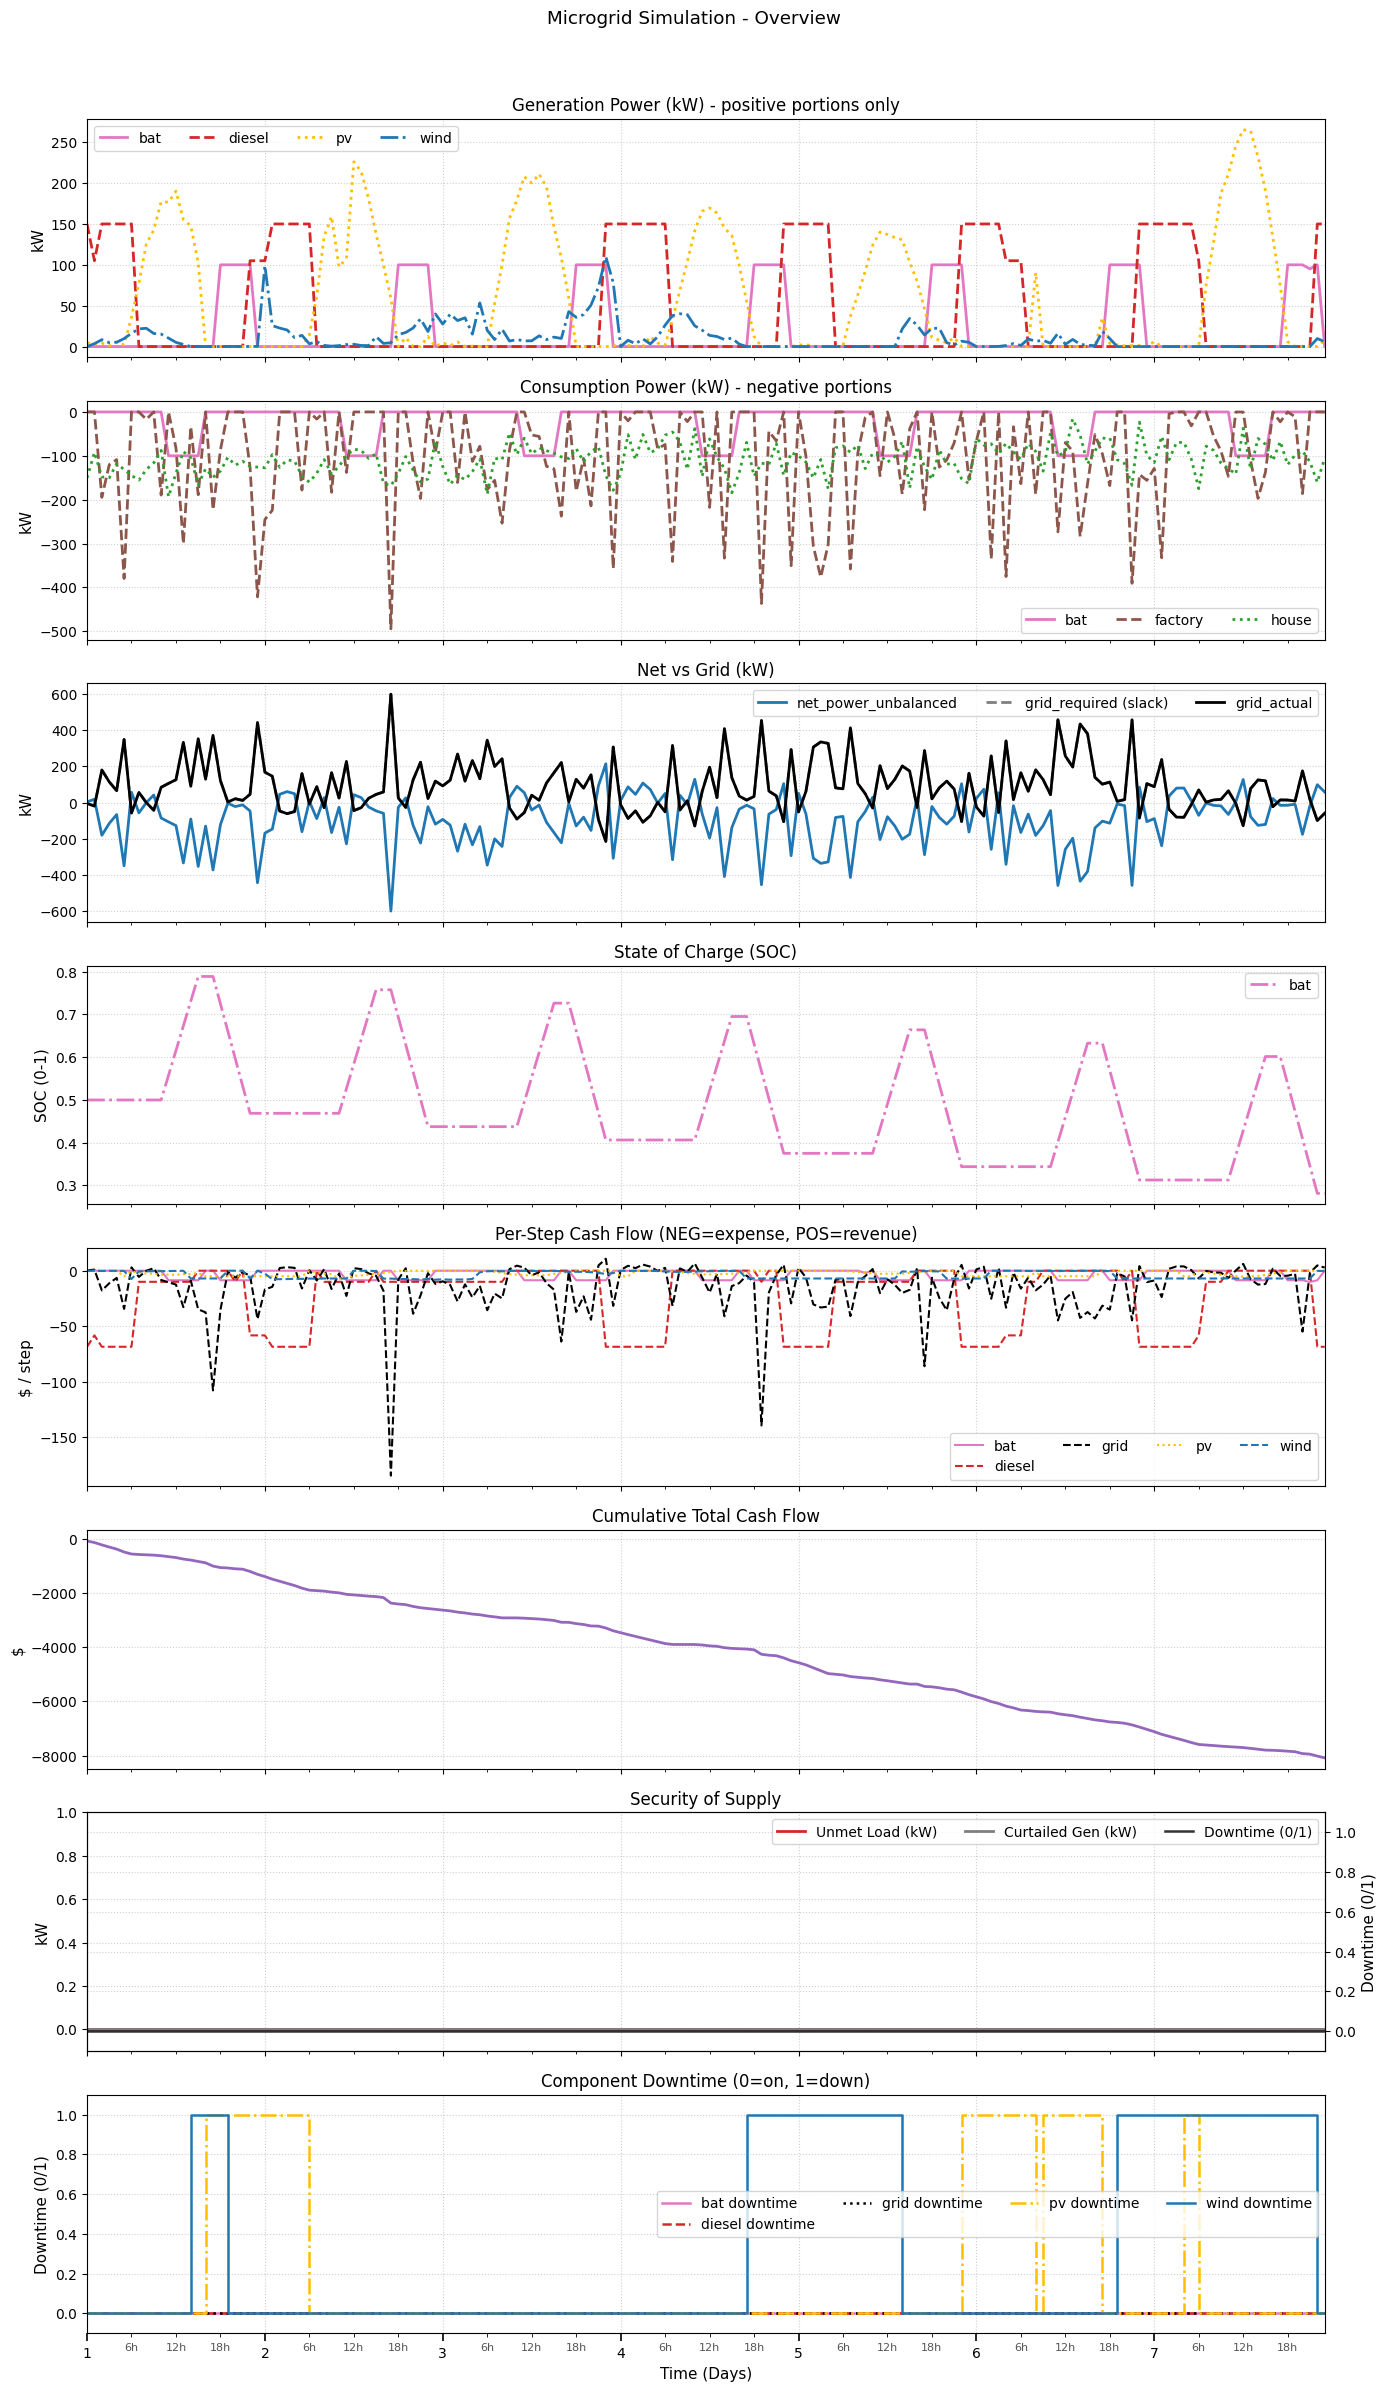

In [5]:
print("\n=== Evaluating Rule-Based EMS ===")

# Create fresh environment for rule-based test
base_env_test.reset()
exog_list_test = data_builder_test.build_list()

ems = setup_ems_controller()
base_env_test.run(controller=ems, exogenous_list=exog_list_test)

df_rule = base_env_test.get_results(as_dataframe=True)
rule_cost = df_rule["total_cashflow"].sum()
rule_cost_avg = df_rule["total_cashflow"].mean()

# Reward Calculation
dt_hours = SIM_DT / 60.0
rule_cash_flow = df_rule["total_cashflow"].sum()
rule_unmet_energy = df_rule["unmet_load_kw"].sum() * dt_hours
rule_curtailed_energy = df_rule["curtailed_gen_kw"].sum() * dt_hours
rule_reward = (
    rule_cash_flow * reward_weights["cost"]
    - rule_unmet_energy * reward_weights["unmet"]
    - rule_curtailed_energy * reward_weights["curtailment"]
)

print(f"Rule-Based EMS - Total Reward: {rule_reward:.2f}")
print(f"Rule-Based EMS - Total Cost: ${rule_cost:.2f}")
print(f"Rule-Based EMS - Average Cost per Timestep: ${rule_cost_avg:.2f}")

# Plot
_ = plot_simulation(
    df_rule,
    sim_dt_minutes=SIM_DT,
    sim_name="05-03_rule_based_ems",
    save=True,
    base_dir=RESULTS_DIR
)

print("Rule-based EMS evaluation complete.\n")

## Test Random Policy (Baseline)


=== Testing Random Policy (Baseline) ===
Random Policy - Steps: 168
Random Policy - Total Reward: -458161.82
Random Policy - Total Cost: $-5681.52
Random Policy - Average Cost per Timestep: $-33.82
Random policy baseline complete.



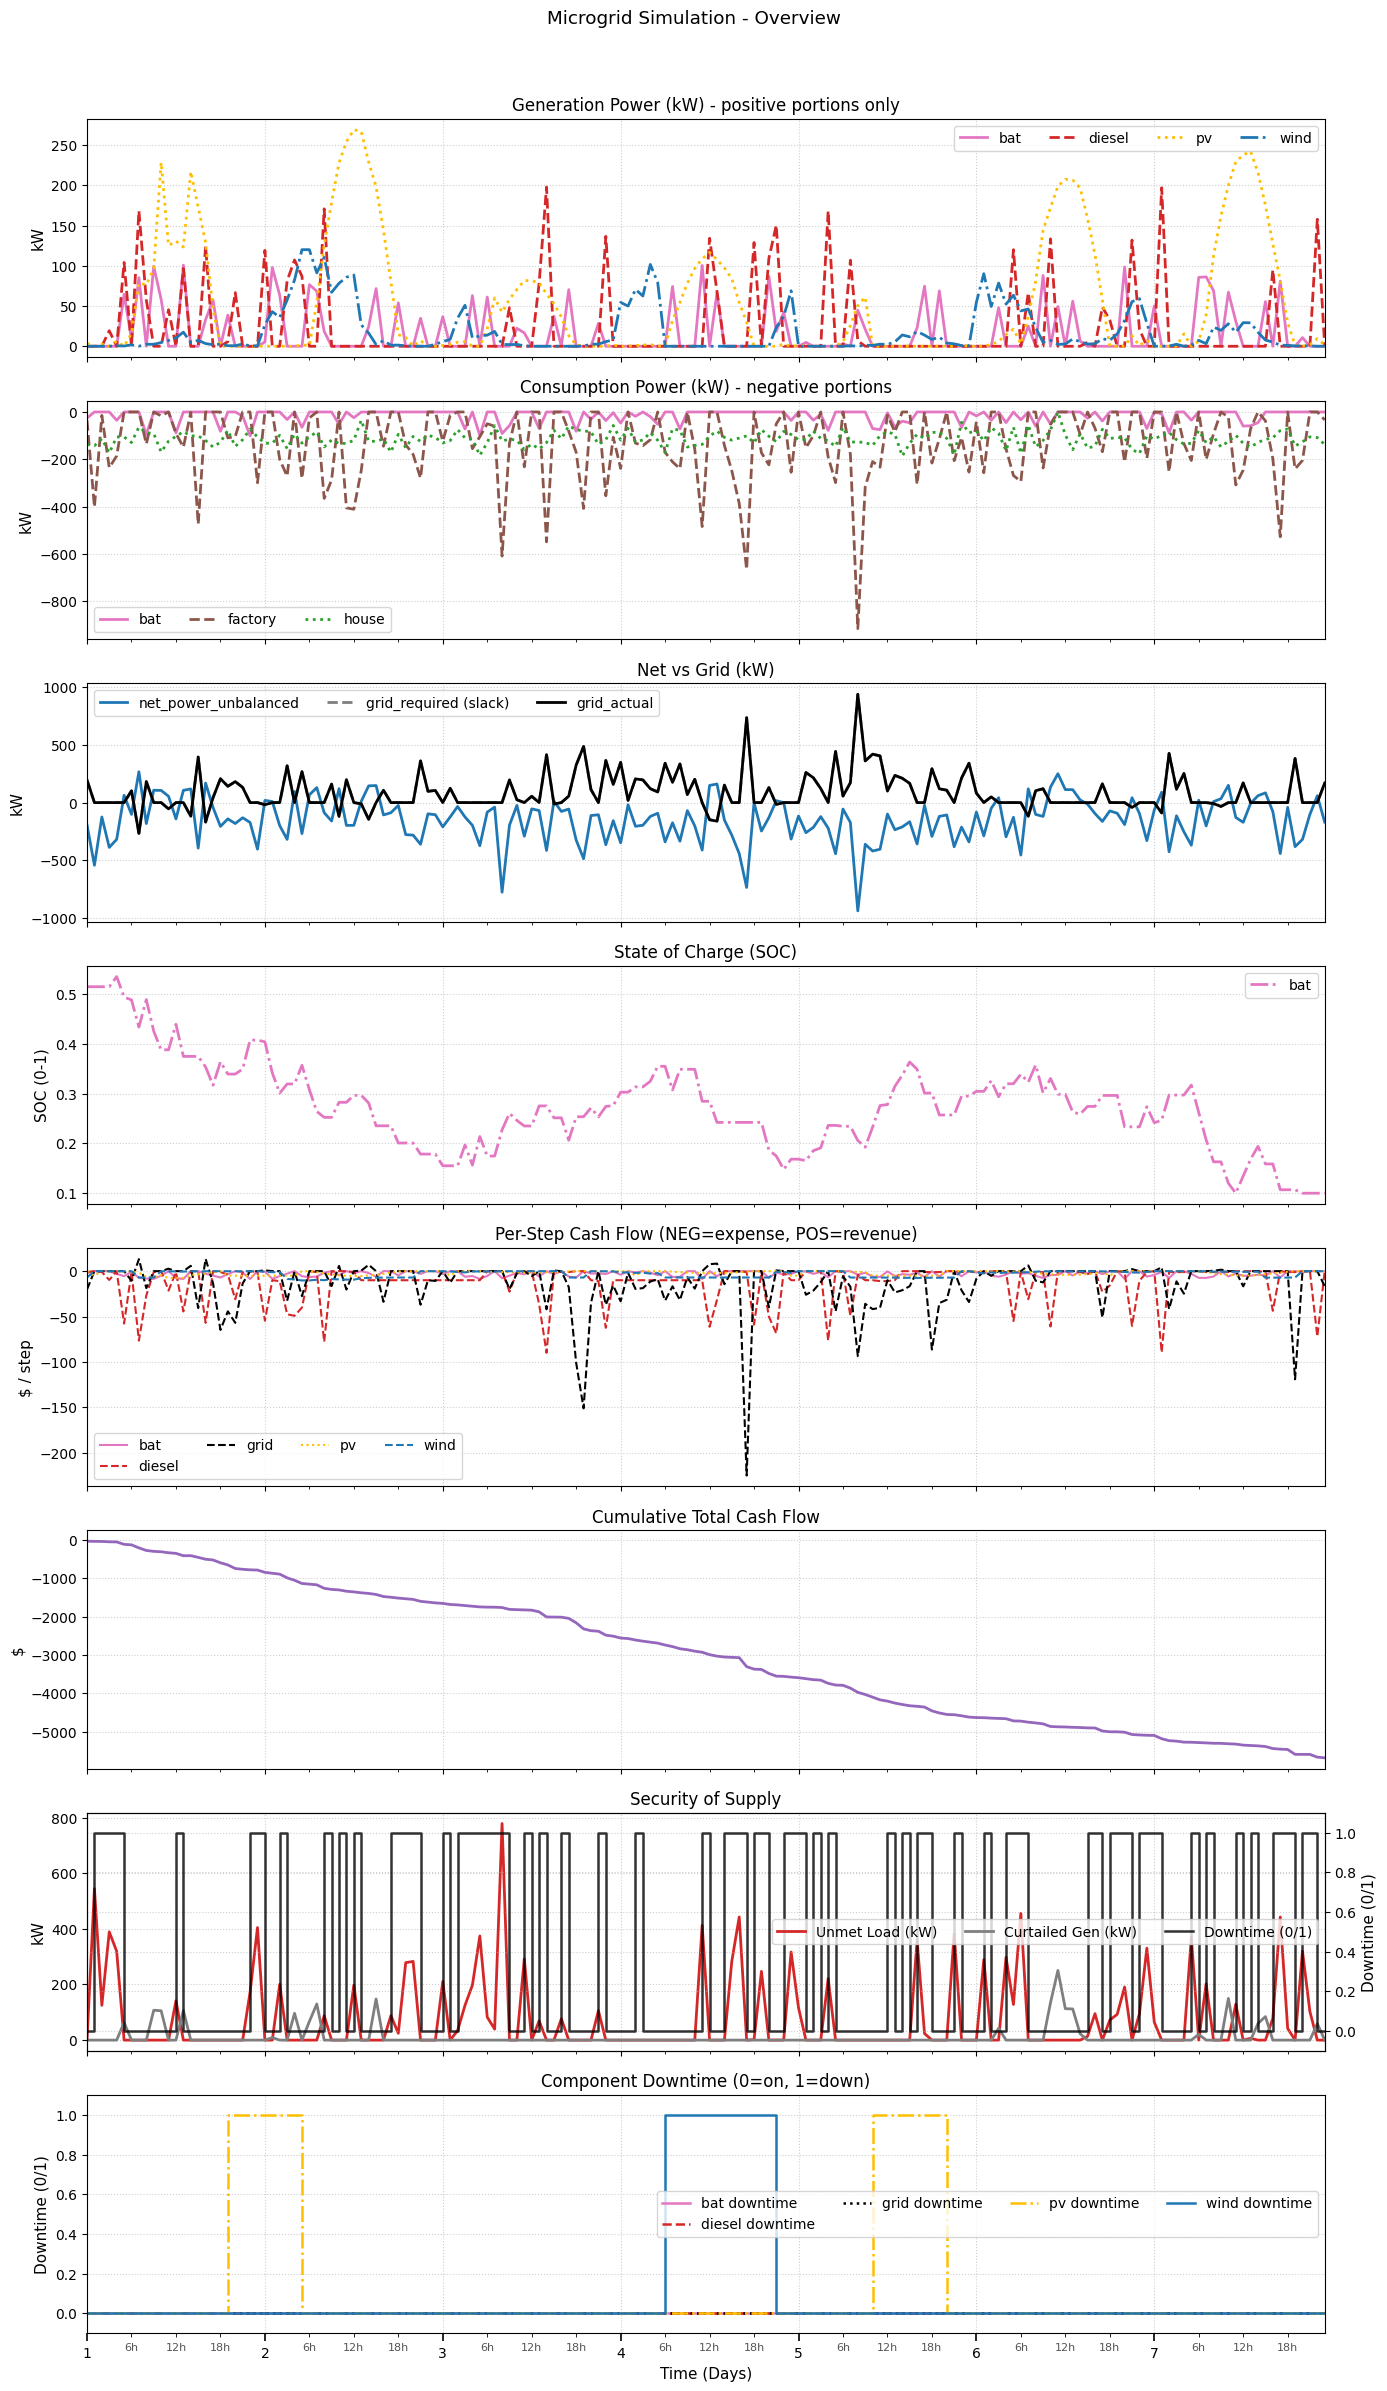

In [6]:
print("\n=== Testing Random Policy (Baseline) ===")

obs, info = test_env.reset(seed=SEED)
episode_reward = 0.0
done = False
step_count = 0

while not done:
    action = test_env.action_space.sample()
    obs, reward, terminated, truncated, info = test_env.step(action)
    done = terminated or truncated
    episode_reward += reward
    step_count += 1

df_random = test_env.unwrapped.env.get_results(as_dataframe=True)
random_cost = df_random["total_cashflow"].sum()
random_cost_avg = df_random["total_cashflow"].mean()
random_reward = episode_reward

print(f"Random Policy - Steps: {step_count}")
print(f"Random Policy - Total Reward: {episode_reward:.2f}")
print(f"Random Policy - Total Cost: ${random_cost:.2f}")
print(f"Random Policy - Average Cost per Timestep: ${random_cost_avg:.2f}")

# Plot
_ = plot_simulation(
    df_random,
    sim_dt_minutes=SIM_DT,
    sim_name="05-01_random_policy",
    save=True,
    base_dir=RESULTS_DIR
)

print("Random policy baseline complete.\n")

## Train RL Agent

In [7]:
print("\n=== Training RL Agent ===")

rl_controller = RLController(
    env=train_env,
    policy='MlpPolicy',
    learning_rate=3e-4,
    n_steps=CONTROL_STEPS_PER_EP,
    batch_size=12,
    n_epochs=5,
    verbose=0
)

rl_controller.train(
    total_timesteps=TRAINING_TIMESTEPS,
    log_dir=LOG_DIR,
    eval_env=eval_env,
    eval_freq=EVAL_FREQ,
    n_eval_episodes=N_EVAL_EPISODES,
)

# Save the trained model
model_path = os.path.join(MODEL_DIR, "ppo_microgrid")
rl_controller.save(model_path)


=== Training RL Agent ===


Output()

(<Figure size 1000x400 with 1 Axes>,
 <Axes: title={'center': 'PPO — Evaluation Reward'}, xlabel='Episode', ylabel='Reward'>)

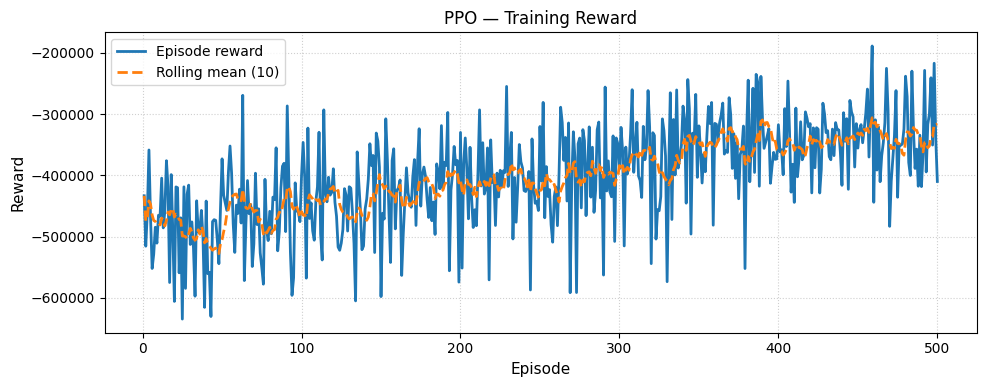

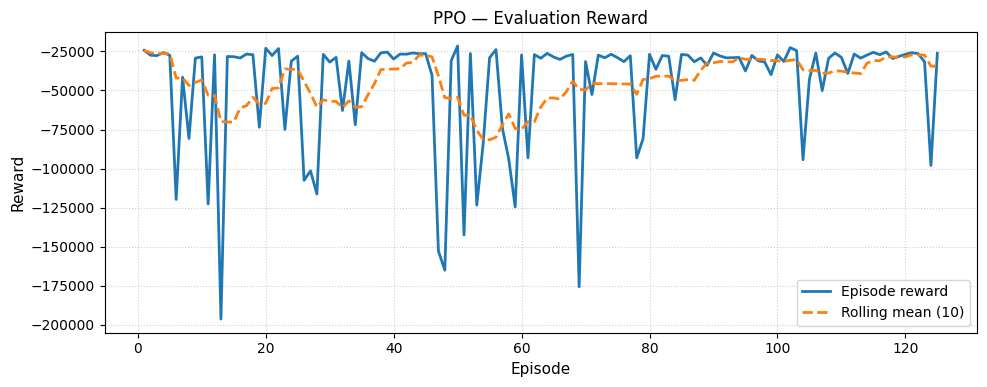

In [8]:
plot_reward_progress(
    f"{train_monitor_path}.monitor.csv",
    title="PPO — Training Reward",
    out_path=os.path.join(RESULTS_DIR, "ppo_reward_progress.png"),
    rolling=10
)

plot_reward_progress(
    f"{eval_monitor_path}.monitor.csv",
    title="PPO — Evaluation Reward",
    out_path=os.path.join(RESULTS_DIR, "ppo_eval_reward_progress.png"),
    rolling=10
)

## Evaluate Trained RL Agent


=== Evaluating Trained RL Agent ===
RL Policy - Steps: 168
RL Policy - Total Reward: -31715.61
RL Policy - Total Cost: $-6343.12
RL Policy - Average Cost per Timestep: $-37.76
RL policy evaluation complete.



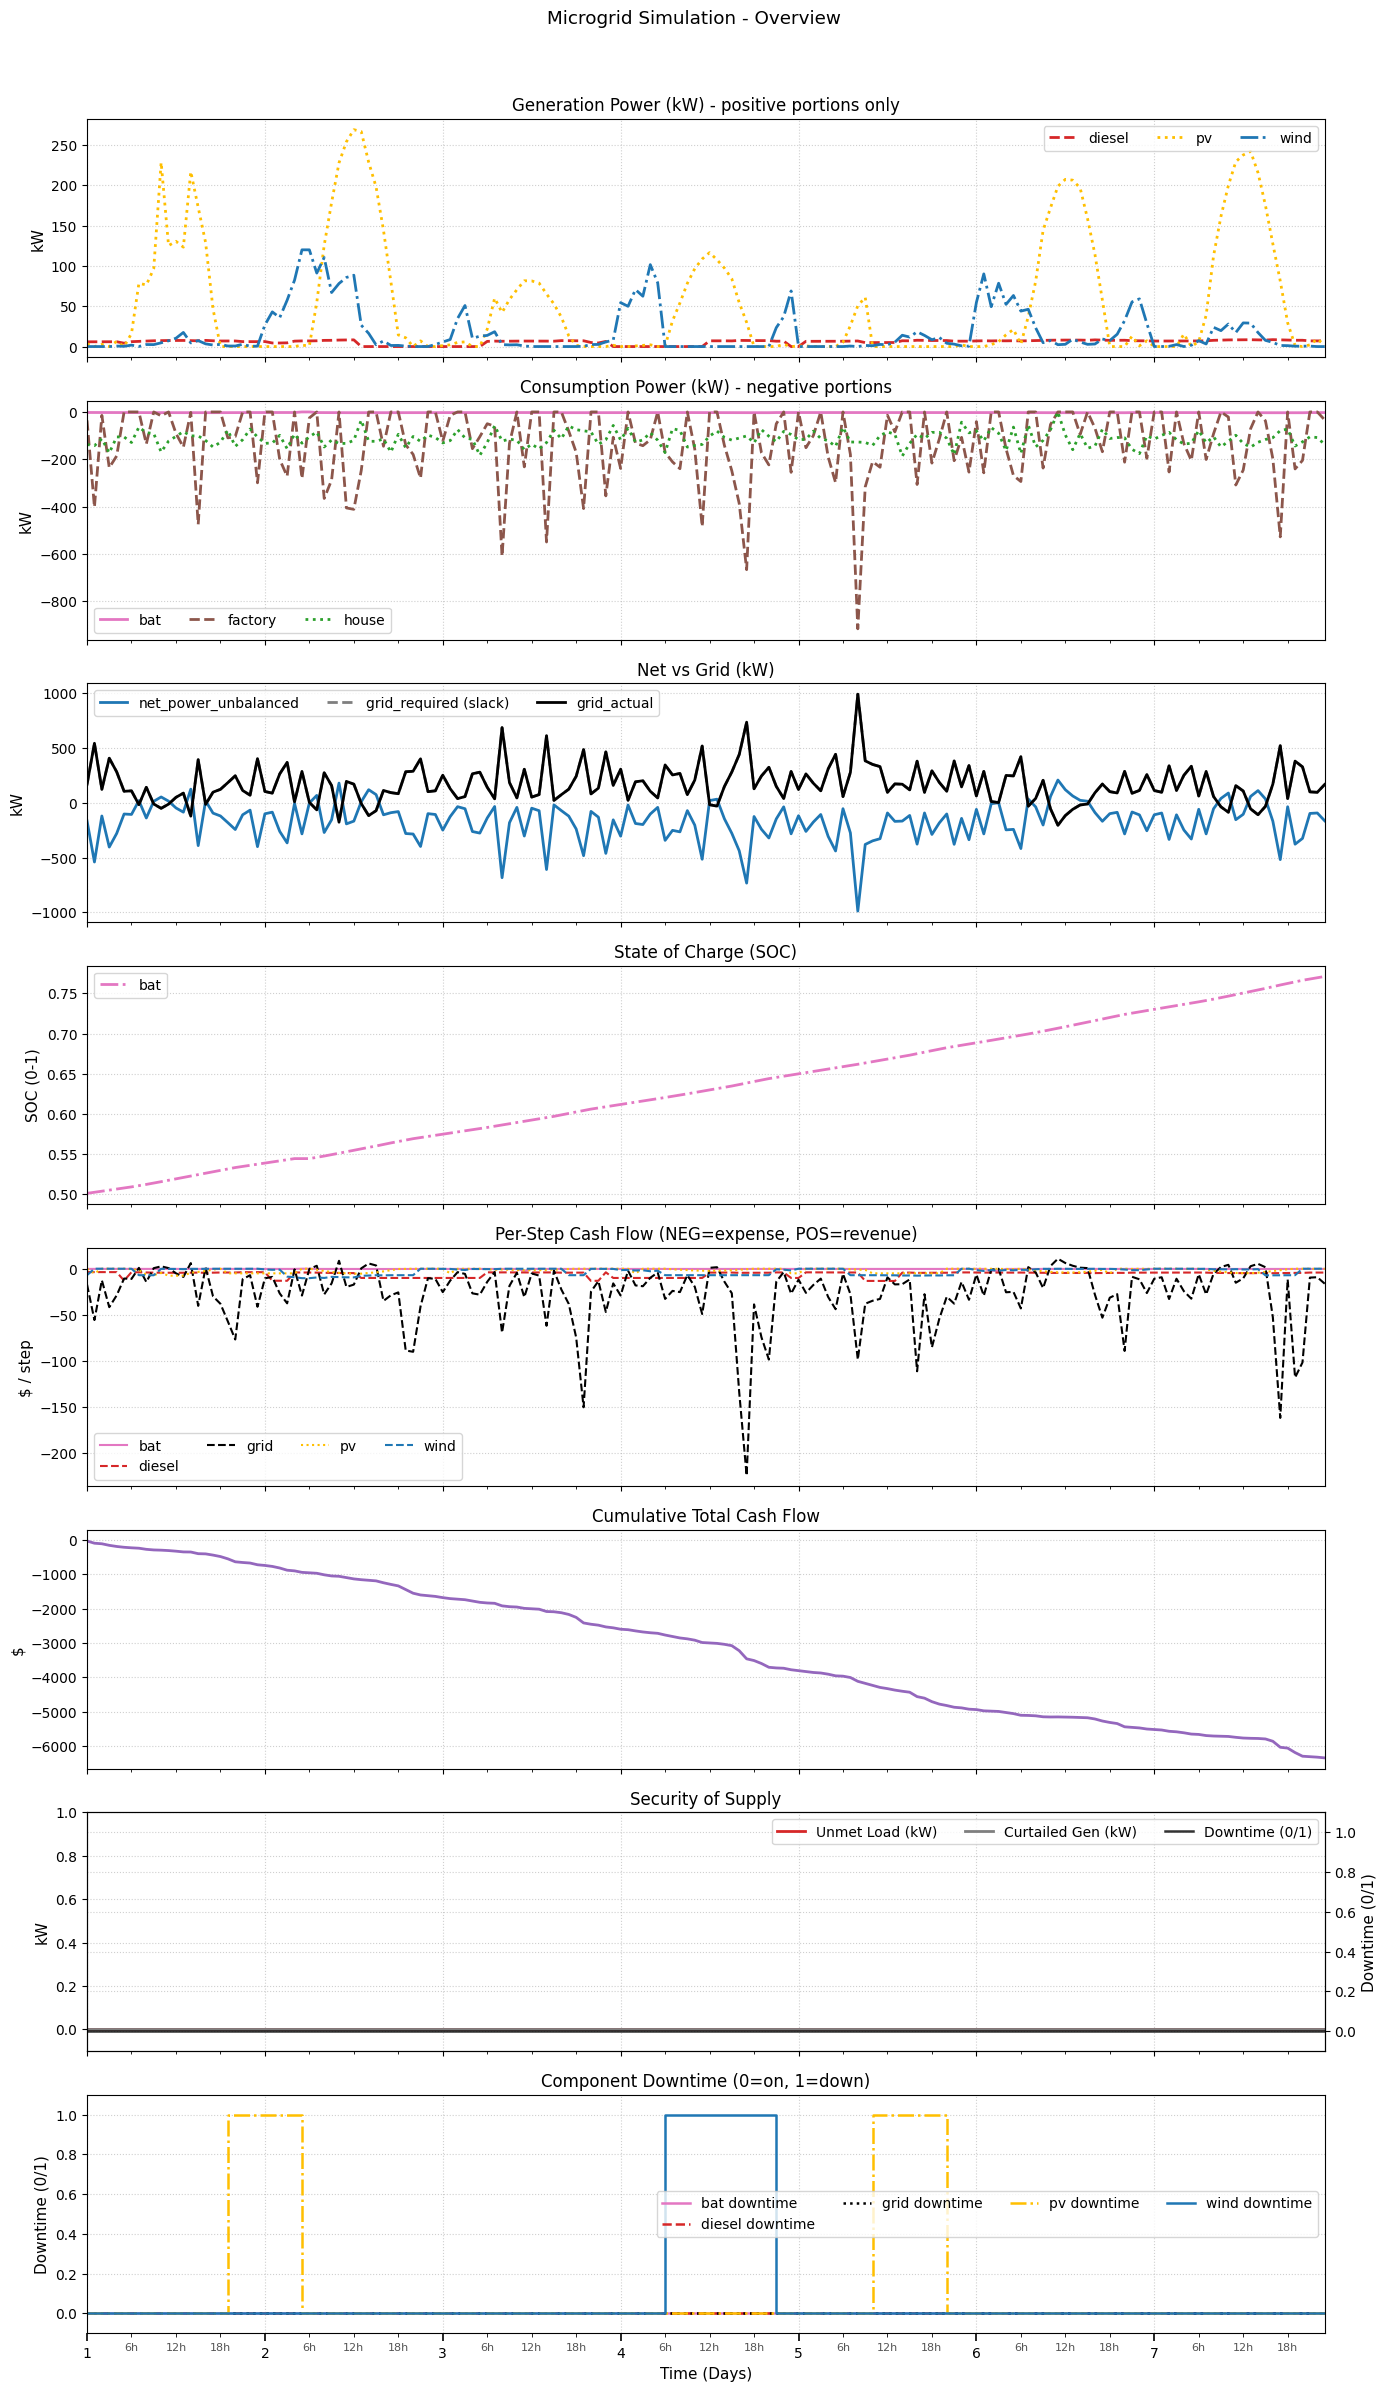

In [9]:
print("\n=== Evaluating Trained RL Agent ===")

obs, info = test_env.reset(seed=SEED)
episode_reward = 0.0
done = False
step_count = 0

while not done:
    action = rl_controller.decide(obs, deterministic=True)
    obs, reward, terminated, truncated, info = test_env.step(action)
    done = terminated or truncated
    episode_reward += reward
    step_count += 1

df_rl = test_env.unwrapped.env.get_results(as_dataframe=True)
rl_cost = df_rl["total_cashflow"].sum()
rl_cost_avg = df_rl["total_cashflow"].mean()
rl_reward = episode_reward

print(f"RL Policy - Steps: {step_count}")
print(f"RL Policy - Total Reward: {episode_reward:.2f}")
print(f"RL Policy - Total Cost: ${rl_cost:.2f}")
print(f"RL Policy - Average Cost per Timestep: ${rl_cost_avg:.2f}")

# Plot
_ = plot_simulation(
    df_rl,
    sim_dt_minutes=SIM_DT,
    sim_name="05-02_rl_policy",
    save=True,
    base_dir=RESULTS_DIR
)

print("RL policy evaluation complete.\n")

## Performance Comparison

In [10]:
print("\n=== Performance Comparison ===")

dt_hours = SIM_DT / 60.0

# Calculate metrics
metrics = {
    "Random Policy": {
        "Total Cost ($)": random_cost,
        "Average Cost per Timestep ($)": random_cost_avg,
        "Unmet Energy (kWh)": df_random["unmet_load_kw"].sum() * dt_hours,
        "Curtailed Energy (kWh)": df_random["curtailed_gen_kw"].sum() * dt_hours,
        "Test Reward": random_reward,
    },
    "Rule-Based EMS": {
        "Total Cost ($)": rule_cost,
        "Average Cost per Timestep ($)": rule_cost_avg,
        "Unmet Energy (kWh)": df_rule["unmet_load_kw"].sum() * dt_hours,
        "Curtailed Energy (kWh)": df_rule["curtailed_gen_kw"].sum() * dt_hours,
        "Test Reward": rule_reward,
    },
    "RL Policy": {
        "Total Cost ($)": rl_cost,
        "Average Cost per Timestep ($)": rl_cost_avg,
        "Unmet Energy (kWh)": df_rl["unmet_load_kw"].sum() * dt_hours,
        "Curtailed Energy (kWh)": df_rl["curtailed_gen_kw"].sum() * dt_hours,
        "Test Reward": rl_reward,
    }
}

# Create comparison table
comparison_df = pd.DataFrame(metrics).T
comparison_df["Total Cost ($)"] = comparison_df["Total Cost ($)"].apply(lambda x: f"${x:,.2f}")
comparison_df["Average Cost per Timestep ($)"] = comparison_df["Average Cost per Timestep ($)"].apply(lambda x: f"${x:,.2f}")
comparison_df["Unmet Energy (kWh)"] = comparison_df["Unmet Energy (kWh)"].apply(lambda x: f"{x:.3f}")
comparison_df["Curtailed Energy (kWh)"] = comparison_df["Curtailed Energy (kWh)"].apply(lambda x: f"{x:.3f}")
comparison_df["Test Reward"] = comparison_df["Test Reward"].apply(lambda x: f"{x:.3f}")

print("\n" + "="*70)
print("🏆 CONTROLLER PERFORMANCE COMPARISON 🏆")
print("="*70)
print(comparison_df.to_string())
print("\nNote: Negative costs are expenses. Lower absolute value is better.")
print("="*70)


=== Performance Comparison ===

🏆 CONTROLLER PERFORMANCE COMPARISON 🏆
               Total Cost ($) Average Cost per Timestep ($) Unmet Energy (kWh) Curtailed Energy (kWh)  Test Reward
Random Policy      $-5,681.52                       $-33.82          12270.626               1881.942  -458161.823
Rule-Based EMS     $-8,085.82                       $-48.13              0.000                  0.000   -40429.085
RL Policy          $-6,343.12                       $-37.76              0.000                  0.000   -31715.612

Note: Negative costs are expenses. Lower absolute value is better.


## Load and Test Saved Model

In [11]:
print("\n=== Testing Model Loading ===")

loaded_controller = RLController.load(
    path=model_path,
    env=eval_env,
    verbose=1
)

# Evaluate loaded model
mean_reward, std_reward = loaded_controller.evaluate(
    env=eval_env,
    n_episodes=3,
    deterministic=True
)

print(f"\nLoaded Model Performance:")
print(f"  Mean Reward: {mean_reward:.2f} +/- {std_reward:.2f}")



=== Testing Model Loading ===
Using cpu device
Wrapping the env in a DummyVecEnv.
PPO model initialized with hyperparameters:
  policy: MultiInputPolicy
  learning_rate: 0.0003
  n_steps: 2048
  batch_size: 64
  n_epochs: 10
  gamma: 0.99
  gae_lambda: 0.95
  clip_range: 0.2
  ent_coef: 0.01
  vf_coef: 0.5
  max_grad_norm: 0.5
  device: auto
  verbose: 1
Model loaded from ./models\ppo_microgrid.zip
Episode 1/3: Reward = -28037.75
Episode 2/3: Reward = -31210.48
Episode 3/3: Reward = -29766.31

Evaluation Results (3 episodes): Mean Reward: -29671.51 +/- 1296.99

Loaded Model Performance:
  Mean Reward: -29671.51 +/- 1296.99
